
X_train shape: (8000, 128)
mask_train shape: (8000, 128)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


Epoch 1/5


C:\Users\USER\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_ids', 'attention_mask']. Received: the structure of inputs=('*', '*')
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 980s 2s/step - accuracy: 0.4425 - loss: 1.7422 - val_accuracy: 0.6225 - val_loss: 1.1667 - learning_rate: 2.0000e-05
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 950s 2s/step - accuracy: 0.5920 - loss: 1.2551 - val_accuracy: 0.6235 - val_loss: 1.1043 - learning_rate: 2.0000e-05
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.5977 - loss: 1.1821 - val_accuracy: 0.6240 - val_loss: 1.0634 - learning_rate: 2.0000e-05
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.6089 - loss: 1.1299 - val_accuracy: 0.6245 - val_loss: 1.0317 - learning_rate: 2.0000e-05
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 938s 2s/step - accuracy: 0.6325 - loss: 1.0715 - val_accuracy: 0.6330 - val_loss: 0.9978 - learning_rate: 2.0000e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.6487 - loss: 0.9680
Test Accuracy: 0.63


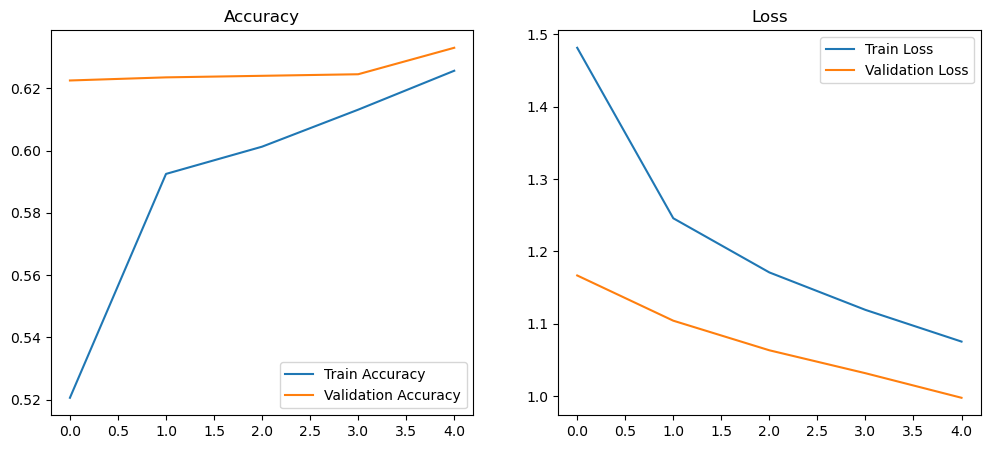

63/63 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step


In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# 為了可以傳入keras input layer
class BertLayer(Layer):
    def __init__(self, bert_model_name='bert-base-uncased', **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained(bert_model_name)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # 返回 [CLS] token 的嵌入
class TransformerCNNClassifier:
    def __init__(self, max_len=128, num_classes=5, learning_rate=2e-5, file_path=r'C:\Users\USER\Desktop\FinalProject\Reviews.csv'):
        self.max_len = max_len
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = None
        self.file_path = file_path
    
    def preprocess_data(self):
        # Load and preprocess data
        df = pd.read_csv(self.file_path)
        df = df[['Text', 'Score']].dropna().head(10000)

        # Use original 1-5 scores for multi-class classification
        texts, labels = df['Text'], df['Score']

        # 清理文本數據
        texts = texts.str.replace(r'[^a-zA-Z0-9\s]', '', regex=True).str.strip()
        
        texts = texts.apply(lambda x: ' '.join(x.split()[:self.max_len]))  # 截斷長文本

        # Tokenizer
        encodings = self.tokenizer(
            list(texts), truncation=True, padding=True, max_length=self.max_len, return_tensors='tf'
        )

        # 檢查 input_ids 是否超出範圍
        vocab_size = self.tokenizer.vocab_size
        input_ids = encodings['input_ids'].numpy()
        if (input_ids >= vocab_size).any():
            raise ValueError("Input IDs exceed vocabulary size. Check your tokenizer or input data.")

        return encodings['input_ids'], encodings['attention_mask'], labels.values
    def build_model(self):
        # Define Transformer + CNN model
        input_ids = Input(shape=(self.max_len,), dtype=tf.int32, name="input_ids")
        attention_mask = Input(shape=(self.max_len,), dtype=tf.int32, name="attention_mask")

        bert_output = BertLayer(bert_model_name='bert-base-uncased')([input_ids, attention_mask])      

        cnn_layer = Conv1D(filters=128, kernel_size=3, activation="relu")(bert_output)
        cnn_layer = GlobalMaxPooling1D()(cnn_layer)
        
        dense_layer = Dense(64, activation="relu")(cnn_layer)
        dense_layer = Dropout(0.5)(dense_layer)
        output = Dense(self.num_classes+1, activation="softmax")(dense_layer)
        
        self.model = Model(inputs=[input_ids, attention_mask], outputs=output)
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    
    def train(self, X_train, y_train, X_val, y_val, batch_size=16, epochs=5):
        # Define callbacks
        callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7),
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks
        )
        return history
    
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)
        print(f"Test Accuracy: {accuracy:.2f}")
        return loss, accuracy
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions.argmax(axis=-1)  # Return the class with the highest probability

def plot_history(history):
    plt.figure(figsize=(12, 5))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    classifier = TransformerCNNClassifier()
    X, masks, y = classifier.preprocess_data()

    # Split data
    X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
        X.numpy(), y, masks.numpy(), test_size=0.2, random_state=42
    )

    # Convert back to TensorFlow tensors
    X_train, X_test = tf.convert_to_tensor(X_train), tf.convert_to_tensor(X_test)
    mask_train, mask_test = tf.convert_to_tensor(mask_train), tf.convert_to_tensor(mask_test)
    print("X_train shape:", X_train.shape)
    print("mask_train shape:", mask_train.shape)
    # Build, train, and evaluate the model
    classifier.build_model()
    history = classifier.train([X_train, mask_train], y_train, [X_test, mask_test], y_test)
    classifier.evaluate([X_test, mask_test], y_test)
    plot_history(history)

    # Save predictions
    predictions = classifier.predict([X_test, mask_test])
    pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).to_csv('evaluation_results.csv', index=False)
    classifier.model.save('transformer_cnn_model.h5')
